In [1]:
import os
import time
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

# from moviepy.editor import *
%matplotlib inline

### Parameters & Hyper-parameters

In [2]:
group_id = 2
test_size = 0.2
batch_size = 4

height, width = 64, 64
num_frames = 20

# Specify the path to the directory containing the folders
DATASET_DIR = "../data/UCF50/" + str(group_id)

# List all classes in the specified path
folders = [folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))]

CLASSES_LIST = folders

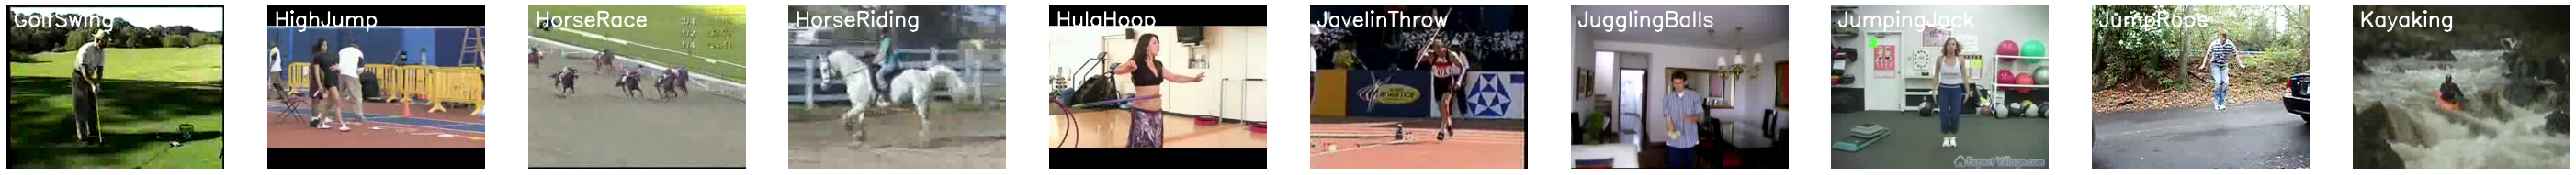

In [3]:
plt.figure(figsize=(50, 50))
all_classes_names = os.listdir(DATASET_DIR)

for counter, selected_class_Name in enumerate(all_classes_names, 1):
    video_files_names_list = os.listdir(f'../data/UCF50/{group_id}/{selected_class_Name}')

    # Check if there are video files in the folder
    if video_files_names_list:
        selected_video_file_name = random.choice(video_files_names_list)
        video_reader = cv2.VideoCapture(f'../data/UCF50/{group_id}/{selected_class_Name}/{selected_video_file_name}')
        _, bgr_frame = video_reader.read()
        video_reader.release()
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        plt.subplot(5, 10, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')
    else:
        print(f"No video file exists in folder {selected_class_Name}")

plt.show()


In [4]:
# Set seed for reproducibility
mySeed = 42
np.random.seed(mySeed)
random.seed(mySeed)
torch.manual_seed(mySeed)

In [5]:
# Function to extract frames from a video
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / num_frames), 1)
    
    for frame_counter in range(num_frames):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (height, width))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

# Custom PyTorch dataset
class VideoDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# Function to create dataset
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)
            if len(frames) == num_frames:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [6]:
# Create dataset
features, labels, video_files_paths = create_dataset()

# Convert labels to one-hot encoding using PyTorch's F.one_hot
labels_one_hot = torch.tensor(np.eye(len(CLASSES_LIST))[labels])

Extracting Data of Class: GolfSwing


Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: HulaHoop
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JugglingBalls
Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: Kayaking


In [7]:
# Train-test split using sklearn's train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels_one_hot, test_size=0.25, shuffle=True, random_state=mySeed
)

# Convert data to PyTorch tensors and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert data to PyTorch tensors
features_train = torch.tensor(features_train).to(device)
labels_train = torch.tensor(labels_train).to(device)
features_test = torch.tensor(features_test).to(device)
labels_test = torch.tensor(labels_test).to(device)

# PyTorch DataLoader
train_dataset = VideoDataset(features_train, labels_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

validation_dataset = VideoDataset(features_test, labels_test)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=True)

<ipython-input-7-b8a25bf621b5>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(labels_train).to(device)
<ipython-input-7-b8a25bf621b5>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(labels_test).to(device)


In [8]:
class LRCNModel(nn.Module):
    def __init__(self):
        super(LRCNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), padding='same')  # Assuming input frames have 3 channels (RGB)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 4))
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(64, 32)
        self.fc = nn.Linear(32, len(CLASSES_LIST))

    def forward(self, x):
        # Reshape input tensor to [batch_size * num_frames, channels, height, width]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4])
        
        # Permute dimensions for convolutional layers
        x = x.permute(0, 3, 1, 2)

        x = self.dropout1(self.pool1(F.relu(self.conv1(x))))
        x = self.dropout2(self.pool2(F.relu(self.conv2(x))))
        x = self.dropout3(self.pool3(F.relu(self.conv3(x))))
        x = self.pool4(F.relu(self.conv4(x)))

        # Flatten the spatial dimensions
        x = self.flatten(x)

        # Permute dimensions for LSTM
        x = x.view(x.shape[0] // num_frames, num_frames, -1).permute(1, 0, 2)

        # Apply LSTM
        x, _ = self.lstm(x)
        x = x[-1, :, :]  # Take the output of the last time step

        # Fully connected layer
        x = self.fc(x)
        return F.softmax(x, dim=1)

In [9]:
# Instantiate the model and move to GPU
lrcn_model = LRCNModel().to(device)
print("Model Created Successfully!")

# before training
start_time = time.time()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lrcn_model.parameters())

Model Created Successfully!


In [11]:
# Training loop
num_epochs = 160

for epoch in range(num_epochs):
    lrcn_model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = lrcn_model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += targets.size(0)
        correct_train_predictions += (predicted == targets).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_samples

    # Validation loop
    lrcn_model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validation_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = lrcn_model(inputs)

            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += targets.size(0)
            correct_val_predictions += (predicted == targets).sum().item()

    avg_val_loss = total_val_loss / len(validation_loader)
    val_accuracy = correct_val_predictions / total_val_samples

    # Print the loss and accuracy for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/160], Training Loss: 2.7547, Training Accuracy: 0.0845, Validation Loss: 2.7747, Validation Accuracy: 0.0145
Epoch [2/160], Training Loss: 2.7504, Training Accuracy: 0.0858, Validation Loss: 2.7614, Validation Accuracy: 0.0188
Epoch [3/160], Training Loss: 2.7365, Training Accuracy: 0.0940, Validation Loss: 2.7469, Validation Accuracy: 0.0283
Epoch [4/160], Training Loss: 2.7339, Training Accuracy: 0.0959, Validation Loss: 2.7332, Validation Accuracy: 0.0343
Epoch [5/160], Training Loss: 2.7106, Training Accuracy: 0.1054, Validation Loss: 2.7232, Validation Accuracy: 0.0429
Epoch [6/160], Training Loss: 2.6990, Training Accuracy: 0.1055, Validation Loss: 2.7054, Validation Accuracy: 0.0517
Epoch [7/160], Training Loss: 2.6921, Training Accuracy: 0.1077, Validation Loss: 2.6948, Validation Accuracy: 0.0594
Epoch [8/160], Training Loss: 2.6796, Training Accuracy: 0.1133, Validation Loss: 2.6805, Validation Accuracy: 0.0609
Epoch [9/160], Training Loss: 2.6781, Training Accuracy: